population

In [4]:
#Routines for scraping and downloading data from http://esa.un.org/unpd/wpp/unpp/panel_indicators.htm
#Source: http://schoolofdata.org/2014/09/12/easy-access-to-world-bank-and-un-development-data-from-ipython-notebooks/

import requests
from bs4 import BeautifulSoup

from io import StringIO
import pandas as pd

def getFormSelectVals(soup,name):
    #Parse out options from an HTML select list
    
    tmp={}
    items=soup.find('select',{'name':name})
    for o in items.findAll('option'):
        #print(o.attrs['value'],o.text.strip())
        tmp[o.text.strip()]=o.attrs['value']
    return tmp


def getUNPopDivIndicators():
    #Grab the UN Population Division indicators page and parse out form values
    
    url='http://esa.un.org/unpd/wpp/unpp/panel_indicators.htm'
    page = requests.get(url)
    
    soup=BeautifulSoup(page.content, "lxml")
    
    unpop={}
    unpop['vars']=getFormSelectVals(soup,'Variable')
    unpop['countries']=getFormSelectVals(soup,'Location')
    unpop['variants']=getFormSelectVals(soup,'Varient')
      
    return unpop

def getUNPopDivData(dfi,country,indicator,variant='Medium variant',startyear=1950,endyear=2100):
    #Download selected data from the UN Population Division indicators page and return it as a pandas dataframe
    
    if not isinstance(country,list): country= [country] 
    if not isinstance(indicator,list): indicator= [indicator]
    
    #Limited to five options - use the first 5
    #For each item, look up the name from the scraped form elements and find what code number to use.
    locations= [dfi['countries'][x] for x in country[:5]]
    variables= [dfi['vars'][x] for x in indicator[:5]]
    
    varient=dfi['variants'][variant]
    
    data=[('Panel',2),('Varient',varient),('StartYear',startyear),('EndYear',endyear),('DoWhat','Download as .CSV File')]
    
    #If we request multiple locations or variables, the form repeats the 'Location' or 'Variable' attribute name
    #This means we can't use a Python dict to represent the arguments - instead we create a list of tuples
    for l in locations: data.append(('Location',l))
    for v in variables: data.append(('Variable',v))
    
    url='http://esa.un.org/unpd/wpp/unpp/p2k0data_script.asp'

    response = requests.post(url,data=data)
    
    #The data is returned as a string - we use StringIO to make it look like a file stream so pd.read_csv() can read it
    #The last two lines of the returned data are an empty line and a metadata line - so let's ignore them.
    #skipfooter currently only works with the python engine - so let's declare that to prevent a warning
    
    #old version with skipfooter, unicode characters represent a problem
    #df=pd.read_csv(StringIO(response.text), skipfooter=2, engine='python', encoding='latin-1')
    
    #new version, unicode OK (you're welcome Côte d'Ivoire)
    df=pd.read_csv(StringIO(response.text))
    df.ix[0:len(df.index)-3]
    
    return df

In [ ]:
url='http://esa.un.org/unpd/wpp/unpp/panel_indicators.htm'
page = requests.get(url)

soup=BeautifulSoup(page.content, "lxml")

unpop={}
unpop['vars']=getFormSelectVals(soup,'Variable')
unpop['countries']=getFormSelectVals(soup,'Location')
unpop['variants']=getFormSelectVals(soup,'Varient')

In [5]:
#Helper routines for working with the data
def search(d, substr):
    #Partial string match search within dict key names
    #via http://stackoverflow.com/a/10796050/454773
    
    result = []
    for key in d:
        if substr.lower() in key.lower():
            result.append((key, d[key])) 

    return result

So that's the code... now how do we use it?

The first thing we need to do is see what indicators are available:

In [6]:
#Get indicators
dfi=getUNPopDivIndicators()

#Preview indicators
dfi['vars']

AttributeError: 'NoneType' object has no attribute 'findAll'

We can also search within indicators to find their proper names.

In [ ]:
#Example search within indicators
search(dfi['vars'],'pop')

The following shows us what prediction variants are supported.

In [6]:
#Show variants of predictions
dfi['variants']

{u'Constant-fertility variant': '5',
 u'High variant': '3',
 u'Low variant': '4',
 u'Medium variant': '2'}

We search for countries by name - but we need to make sure we pass the name in correctly. So search to find out...

In [217]:
#Example search within country names
search(dfi['countries'],'united')

[(u'United States of America', '840'),
 (u'United Republic of Tanzania', '834'),
 (u'United States Virgin Islands', '850'),
 (u'United Arab Emirates', '784'),
 (u'United Kingdom', '826')]

Once we know what we want to ask for, we can make a data request.

In [7]:
#Let's run a test query
pop=getUNPopDivData(dfi,['World'],
                      ['Population by sex (annual)'])
pop=pop.query('Sex=="Total"').drop(['Sex','Variable','Variant'],axis=1).set_index(['Country','Year'])

NameError: name 'dfi' is not defined

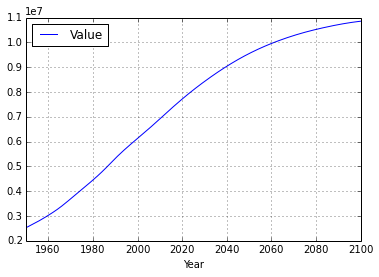

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
pop.loc['World'].plot()

UN POP Stats API can take calls only for max 5 countries at a time. Let's split the country list into batches of 5 and do the calls.

In [65]:
def split(arr, size):
     arrs = []
     while len(arr) > size:
         pice = arr[:size]
         arrs.append(pice)
         arr   = arr[size:]
     arrs.append(arr)
     return arrs

In [195]:
#Make all calls - could take up to 5 minutes based on your internet connection and processor speed
n = len(split(list(dfi['countries']),5))
pop = pd.DataFrame()
for i in range(n):
    print round((i+1)/float(n),2)
    pop2=getUNPopDivData(dfi,split(list(dfi['countries']),5)[i],
                          ['Population by sex (annual)'])
    pop2=pop2.query('Sex=="Total"').drop(['Sex','Variable','Variant'],axis=1).set_index(['Country','Year'])
    pop=pd.concat([pop,pop2])
    
#save to file to avoid running again
file('pop.json','w').write(pop.to_csv())

In [227]:
file('pop.csv','w').write(pop.to_csv())

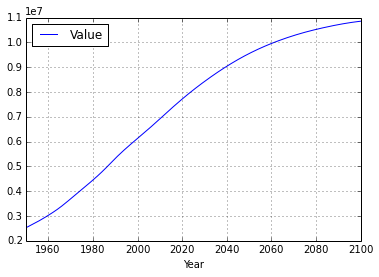

In [226]:
pop.loc['World'].plot()